In [1]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn
import torch

In [2]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

# Datasets
trainset = datasets.MNIST('dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('dataset/test', download=True, train=False, transform=transform)

# Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [3]:
# Initialize weights and biases
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
weights = {
    'h1': np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(1. / input_size),
    'h2': np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(1. / hidden_sizes[0]),
    'out': np.random.randn(hidden_sizes[1], output_size) * np.sqrt(1. / hidden_sizes[1])
}
biases = {
    'h1': np.zeros(hidden_sizes[0]),
    'h2': np.zeros(hidden_sizes[1]),
    'out': np.zeros(output_size)
}

In [4]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def forward_pass(x, weights, biases):
    z1 = np.dot(x, weights['h1']) + biases['h1']
    a1 = relu(z1)
    z2 = np.dot(a1, weights['h2']) + biases['h2']
    a2 = relu(z2)
    z3 = np.dot(a2, weights['out']) + biases['out']
    output = softmax(z3)
    return output, z1, a1, z2, a2

def backward_pass(x, y, output, z1, a1, z2, a2, weights, lr):
    m = y.shape[0]
    one_hot_y = np.zeros_like(output)
    one_hot_y[np.arange(m), y] = 1
    dz3 = output - one_hot_y
    dw3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0) / m
    dz2 = np.dot(dz3, weights['out'].T) * (a2 > 0)
    dw2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0) / m
    dz1 = np.dot(dz2, weights['h2'].T) * (a1 > 0)
    dw1 = np.dot(x.T, dz1) / m
    db1 = np.sum(dz1, axis=0) / m

    weights['out'] -= lr * dw3
    biases['out'] -= lr * db3
    weights['h2'] -= lr * dw2
    biases['h2'] -= lr * db2
    weights['h1'] -= lr * dw1
    biases['h1'] -= lr * db1

def compute_accuracy(data_loader, weights, biases):
    correct_count, all_count = 0, 0
    for images, labels in data_loader:
        images = images.view(images.shape[0], -1).numpy()
        labels = labels.numpy()
        output, _, _, _, _ = forward_pass(images, weights, biases)
        predictions = np.argmax(output, axis=1)
        correct_count += (predictions == labels).sum()
        all_count += labels.shape[0]
    return correct_count / all_count

Epoch 1 - Training loss: 1.1457, Validation Accuracy: 0.8514
Epoch 2 - Training loss: 0.4898, Validation Accuracy: 0.8869
Epoch 3 - Training loss: 0.3923, Validation Accuracy: 0.8974
Epoch 4 - Training loss: 0.3521, Validation Accuracy: 0.9082
Epoch 5 - Training loss: 0.3282, Validation Accuracy: 0.9109
Epoch 6 - Training loss: 0.3109, Validation Accuracy: 0.9135
Epoch 7 - Training loss: 0.2974, Validation Accuracy: 0.9175
Epoch 8 - Training loss: 0.2861, Validation Accuracy: 0.9212
Epoch 9 - Training loss: 0.2748, Validation Accuracy: 0.9208
Epoch 10 - Training loss: 0.2655, Validation Accuracy: 0.9251
Epoch 11 - Training loss: 0.2565, Validation Accuracy: 0.9295
Epoch 12 - Training loss: 0.2481, Validation Accuracy: 0.9305
Epoch 13 - Training loss: 0.2403, Validation Accuracy: 0.9309
Epoch 14 - Training loss: 0.2322, Validation Accuracy: 0.9341
Epoch 15 - Training loss: 0.2252, Validation Accuracy: 0.9342


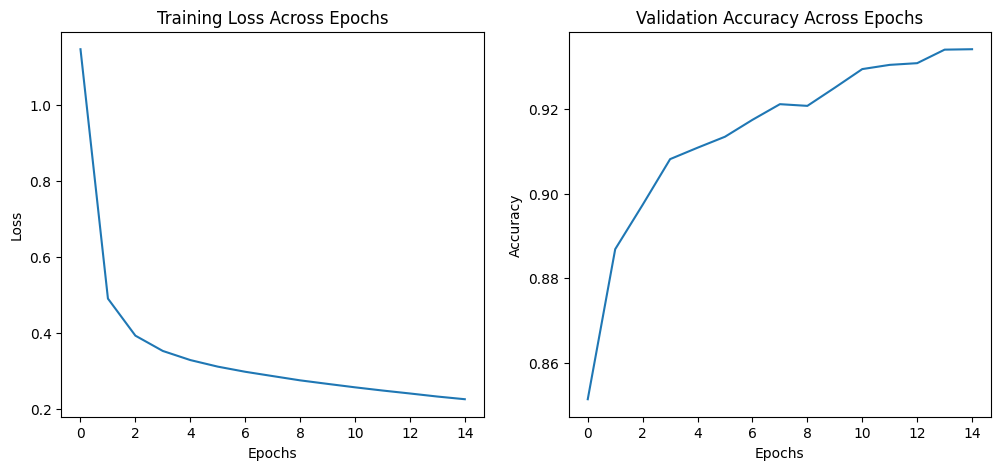

In [5]:
# Training
epochs = 15
lr = 0.003
training_losses = []
validation_accuracies = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten and convert to numpy
        images = images.view(images.shape[0], -1).numpy()
        labels = labels.numpy()

        # Forward pass
        output, z1, a1, z2, a2 = forward_pass(images, weights, biases)

        # Compute loss (Cross-entropy)
        one_hot_labels = np.zeros_like(output)
        one_hot_labels[np.arange(labels.shape[0]), labels] = 1
        loss = -np.mean(np.log(np.sum(output * one_hot_labels, axis=1)))

        # Backward pass
        backward_pass(images, labels, output, z1, a1, z2, a2, weights, lr)

        running_loss += loss
    else:
        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)
        validation_accuracy = compute_accuracy(valloader, weights, biases)
        validation_accuracies.append(validation_accuracy)
        print(f"Epoch {e+1} - Training loss: {training_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

# Plotting Training Loss and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Epochs')
plt.show()
